In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from geopy.distance import great_circle
import mplleaflet

Load data

In [4]:
# Load data from the CSV file into a new DataFrame
data = pd.read_csv('./model/gps_data2.csv')
data

,Taxi ID,Timestamp,Longitude,Latitude
0,1,2008-02-02 15:36:08,116.51172,39.92123
1,1,2008-02-02 15:46:08,116.51135,39.93883
2,1,2008-02-02 15:46:08,116.51135,39.93883
3,1,2008-02-02 15:56:08,116.51627,39.91034
4,1,2008-02-02 16:06:08,116.47186,39.91248
...,...,...,...,...
17662979,9999,2008-02-08 17:11:13,116.27644,39.99720
17662980,9999,2008-02-08 17:16:15,116.28298,39.99740
17662981,9999,2008-02-08 17:21:17,116.28896,39.99235
17662982,9999,2008-02-08 17:26:19,116.28925,39.98273


Sort and convert timestamp into date data

In [5]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['TimeDifference'] = round(data.groupby('Taxi ID')['Timestamp'].diff().dt.total_seconds() / 60)
print(data)

          Taxi ID           Timestamp  Longitude  Latitude  TimeDifference
0               1 2008-02-02 15:36:08  116.51172  39.92123             NaN
1               1 2008-02-02 15:46:08  116.51135  39.93883            10.0
2               1 2008-02-02 15:46:08  116.51135  39.93883             0.0
3               1 2008-02-02 15:56:08  116.51627  39.91034            10.0
4               1 2008-02-02 16:06:08  116.47186  39.91248            10.0
...           ...                 ...        ...       ...             ...
17662979     9999 2008-02-08 17:11:13  116.27644  39.99720             5.0
17662980     9999 2008-02-08 17:16:15  116.28298  39.99740             5.0
17662981     9999 2008-02-08 17:21:17  116.28896  39.99235             5.0
17662982     9999 2008-02-08 17:26:19  116.28925  39.98273             5.0
17662983     9999 2008-02-08 17:36:23  116.26768  39.90663            10.0

[17662984 rows x 5 columns]


In [6]:
timeDiff = data['TimeDifference'].value_counts(normalize=True) * 100

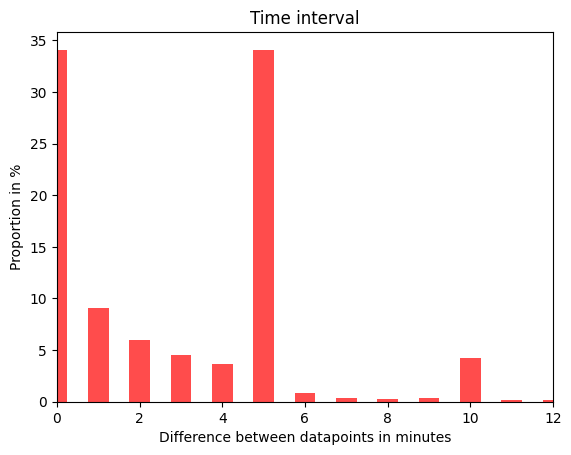

In [7]:
x = timeDiff.index
y = timeDiff.values

# Create a bar chart
plt.bar(x, y, color='red', alpha=0.7, width=0.5)
plt.ylabel('Proportion in %')
plt.xlabel('Difference between datapoints in minutes')
plt.title('Time interval')
plt.xlim(0, 12)
plt.show()

In [8]:
# ChatGPT generated function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c  # Distance in kilometers
    return distance * 1000  # Convert to meters

data['DistanceDifference'] = data.groupby('Taxi ID').apply(
    lambda group: haversine(group['Latitude'], group['Longitude'], group['Latitude'].shift(), group['Longitude'].shift())
).reset_index(drop=True)

data = data[data['Taxi ID'] == data['Taxi ID'].shift(-1)]

In [9]:
data.loc[:, 'DistanceDifference'] = (data['DistanceDifference'] / 1000).round() * 1000
distDiff = data['DistanceDifference'].value_counts(normalize=True) * 100

Distance interval

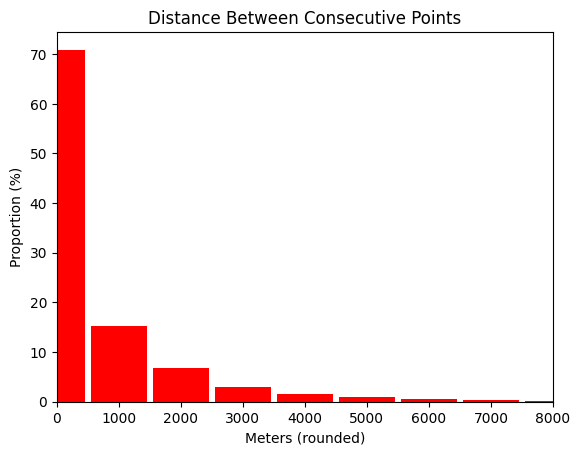

In [10]:
x = distDiff.index
y = distDiff.values

plt.bar(x, y, width=900, color='red')
plt.xlabel('Meters (rounded)')
plt.ylabel('Proportion (%)')
plt.title('Distance Between Consecutive Points')
plt.xlim(0, 8000)
plt.show()

Recude data to Beijing Metro only

In [11]:
data = data[data['Latitude'] >= 39.75]
data = data[data['Latitude'] <= 40.1]
data = data[data['Longitude'] >= 116.18]
data = data[data['Longitude'] <= 116.6]

GPS data distribution

Display on a map

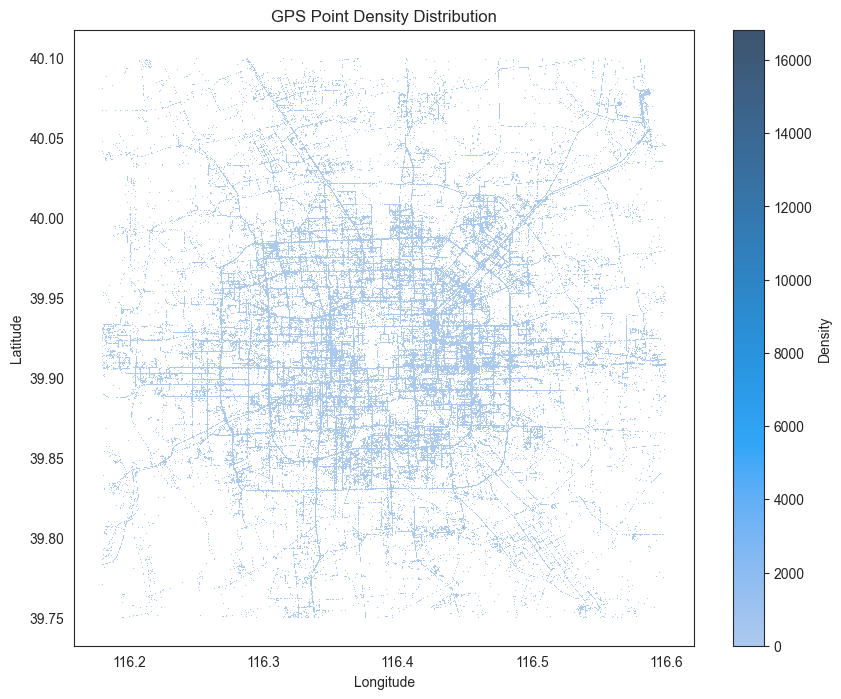

In [23]:
import folium
from folium.plugins import HeatMap

# Create a folium map centered on Beijing
my_map = folium.Map(location=[39.90, 116.41], zoom_start=12)

sns.set_style("white")
fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(data=data, x='Longitude', y='Latitude', bins=2600, cbar=True, cbar_kws={'label': 'Density'}, ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('GPS Point Density Distribution')

plt.savefig('./img/density_plot.png', dpi=300)

In [22]:
# TODO
# https://www.analyticsvidhya.com/blog/2020/06/guide-geospatial-analysis-folium-python/#Plotting_Paths_using_Folium